# Read and prepare raw data for inference

## import and functions

In [2]:
import uproot
import awkward as ak
import numpy as np
from scipy.stats import skew
import matplotlib.pyplot as plt
import torch

from TrackSelectorDNN.models.preprocessing import FeaturePreprocessing 
from torch.utils.data import random_split
from TrackSelectorDNN.data_manager.dataset import TrackDatasetFromFile

In [3]:
def normalize_features(x, eps=1e-8):
    mean = np.mean(x, axis=(0, 1), keepdims=True)
    std = np.std(x, axis=(0, 1), keepdims=True)
    x_norm = (x - mean) / (std + eps)
    return x_norm, mean, std

def normalize_2d(x, eps=1e-8):
    mean = np.nanmean(x, axis=0, keepdims=True)
    std = np.nanstd(x, axis=0, keepdims=True)
    return (x - mean) / (std + eps), mean, std
    
def summarize_features(X, recoPixelTrackFeatures_names):
    summary = []
    for i, name in enumerate(recoPixelTrackFeatures_names):
        x = X[:, i]
        x_clean = x[~np.isnan(x)]
        min_val = np.min(x_clean)
        max_val = np.max(x_clean)
        mean_val = np.mean(x_clean)
        std_val = np.std(x_clean)
        zero_frac = np.sum(np.isclose(x_clean, 0)) / len(x_clean)
        nan_frac = np.sum(np.isnan(x)) / len(x)
        s = skew(x_clean)
        summary.append({
            "feature": name,
            "min": min_val,
            "max": max_val,
            "mean": mean_val,
            "std": std_val,
            "zeros(%)": 100*zero_frac,
            "NaNs(%)": 100*nan_frac,
            "skew": s
        })
    return summary

def print_summary_table(summary, sort_by="skew", top=10):
    import pandas as pd
    df = pd.DataFrame(summary)
    df_sorted = df.sort_values(by=sort_by, key=lambda x: np.abs(x), ascending=False)
    print(df_sorted.head(top).to_string(index=False))
    return df_sorted

def flag_outliers(summary, std_threshold=100, skew_threshold=5, zero_frac_threshold=80):
    issues = []
    for row in summary:
        if np.isnan(row["std"]) or row["std"] == 0:
            issues.append((row["feature"], "Constant or NaN std"))
        if abs(row["skew"]) > skew_threshold:
            issues.append((row["feature"], f"Highly skewed ({row['skew']:.2f})"))
        if row["zeros(%)"] > zero_frac_threshold:
            issues.append((row["feature"], f"Mostly zeros ({row['zeros(%)']:.1f}%)"))
        if abs(row["max"] - row["min"]) > std_threshold * row["std"]:
            issues.append((row["feature"], "Extreme outlier range"))
    print("\n Potentially problematic features:")
    for f, msg in issues:
        print(f" - {f:30s}: {msg}")
    return issues

def clip_outliers(x, low=0.001, high=0.999):
    lo, hi = np.percentile(x, [100*low, 100*high])
    return np.clip(x, lo, hi), lo, hi

def plot_feature_distributions(
    X_ref,
    feature_names,
    y=None,
    X_cmp=None,
    labels=("Reference", "Comparison"),
    n_cols=4,
    bins=50,
    figsize=(16, 12),
    density=True,
    alpha_ref=0.6,
    alpha_cmp=0.4,
):
    """
    Plot feature distributions for one or two datasets.

    Parameters
    ----------
    X_ref : np.ndarray
        Reference dataset of shape (n_samples, n_features).
    feature_names : list of str
        Names of the features to plot.
    y : np.ndarray, optional
        Binary labels (True/False or 1/0). If given, separate histograms by class.
    X_cmp : np.ndarray, optional
        Comparison dataset (same shape as X_ref) to overlay.
    labels : tuple(str, str)
        Labels for the legend corresponding to (X_ref, X_cmp).
    n_cols : int
        Number of subplot columns.
    bins : int
        Number of histogram bins.
    figsize : tuple
        Overall figure size.
    density : bool
        Whether to normalize histograms to density.
    alpha_ref : float
        Transparency for reference histograms.
    alpha_cmp : float
        Transparency for comparison histograms.
    """

    n_features = X_ref.shape[1]
    n_rows = int(np.ceil(n_features / n_cols))
    plt.figure(figsize=figsize)

    for i, name in enumerate(feature_names):
        plt.subplot(n_rows, n_cols, i + 1)

        # Determine plotting mode
        if y is not None:
            mask_true = (y == 1)
            mask_fake = (y == 0)
            plt.hist(
                X_ref[mask_true, i], bins=bins, alpha=alpha_ref,
                label=f"{labels[0]} True", density=density
            )
            plt.hist(
                X_ref[mask_fake, i], bins=bins, alpha=alpha_ref,
                label=f"{labels[0]} Fake", density=density
            )
            if X_cmp is not None:
                plt.hist(
                    X_cmp[mask_true, i], bins=bins, alpha=alpha_cmp,
                    label=f"{labels[1]} True", density=density, linestyle="dashed"
                )
                plt.hist(
                    X_cmp[mask_fake, i], bins=bins, alpha=alpha_cmp,
                    label=f"{labels[1]} Fake", density=density, linestyle="dashed"
                )
        else:
            plt.hist(X_ref[:, i], bins=bins, alpha=alpha_ref, label=labels[0], density=density)
            if X_cmp is not None:
                plt.hist(X_cmp[:, i], bins=bins, alpha=alpha_cmp, label=labels[1], density=density)

        plt.title(name, fontsize=8)
        plt.tick_params(axis="x", labelsize=7)
        plt.tick_params(axis="y", labelsize=7)

    plt.tight_layout()
    plt.legend(fontsize=7)
    plt.show()

In [4]:
#INPUT_PATH = "ext.root"
INPUT_PATH  = "/shared/data/100_tracks_train_dataset.root"

PREPROCESS_PATH = "/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/TrackSelectorDNN/data/tracks_train-val_dataset_extended.pt"
PREPROCESS_PATH_TRAIN = "/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/TrackSelectorDNN/data/tracks_train_dataset_extended.pt"
PREPROCESS_PATH_VAL = "/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/TrackSelectorDNN/data/tracks_val_dataset_extended.pt"

OUTPUT_PATH = "/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/TrackSelectorDNN/data/tracks_train-val_dataset_inference.pt"
OUTPUT_PATH_TRAIN = "/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/TrackSelectorDNN/data/tracks_train_dataset_inference.pt"
OUTPUT_PATH_VAL  = "/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/TrackSelectorDNN/data/tracks_val_dataset_inference.pt"
MAX_HITS = 16

LOW_PERCENTILE  = 0.001
HIGH_PERCENTILE = 0.999
EPSILON = 1.e-8

## Read data from file

In [5]:
# Open the ROOT file
file = uproot.open(INPUT_PATH)
print(file.keys())

print("")
print("-----------------------------------------------")
print("-----------------------------------------------")
print("")

# Access the Events TTree
events = file["Events"]

# List branches in Events
print("Branches in Events:")

for branch in events.keys():
# Inspect first few entries
    print("   -", branch)

# Read all branches into an awkward array
data = events.arrays(library="ak")

['Events;1', 'LuminosityBlocks;1', 'Runs;1', 'MetaData;1', 'ParameterSets;1']

-----------------------------------------------
-----------------------------------------------

Branches in Events:
   - run
   - luminosityBlock
   - event
   - bunchCrossing
   - orbitNumber
   - nGenJet
   - GenJet_eta
   - GenJet_mass
   - GenJet_phi
   - GenJet_pt
   - nGenPart
   - GenPart_genPartIdxMother
   - GenPart_statusFlags
   - GenPart_pdgId
   - GenPart_status
   - GenPart_eta
   - GenPart_mass
   - GenPart_phi
   - GenPart_pt
   - nhltPixelTrackRecHits
   - hltPixelTrackRecHits_globalX
   - hltPixelTrackRecHits_globalY
   - hltPixelTrackRecHits_globalZ
   - hltPixelTrackRecHits_globalErrX
   - hltPixelTrackRecHits_globalErrY
   - hltPixelTrackRecHits_globalErrZ
   - hltPixelTrackRecHits_globalR
   - hltPixelTrackRecHits_globalEta
   - hltPixelTrackRecHits_globalPhi
   - nhltPixelTrack
   - hltPixelTrack_isHighPurity
   - hltPixelTrack_isTight
   - hltPixelTrack_duplicate
   - hltPixelTrack_m

Decide which branches contain either input features or output labels

In [6]:
recHitBranches = [
    "hltPixelTrackRecHits_globalX",
    "hltPixelTrackRecHits_globalY",
    "hltPixelTrackRecHits_globalZ",
    "hltPixelTrackRecHits_globalErrX",
    "hltPixelTrackRecHits_globalErrY",
    "hltPixelTrackRecHits_globalErrZ",
    "hltPixelTrackRecHits_globalR",
    "hltPixelTrackRecHits_globalEta",
    "hltPixelTrackRecHits_globalPhi"
]

recoPixelTrackBranches = [
    "hltPixelTrack_matched",
    "hltPixelTrack_isHighPurity",
    "hltPixelTrack_nPixelHits",
    "hltPixelTrack_nTrkLays",
    "hltPixelTrack_charge",
    "hltPixelTrack_chi2",
    "hltPixelTrack_dXY",
    "hltPixelTrack_dZ",
    "hltPixelTrack_dZError",
    "hltPixelTrack_dsz",
    "hltPixelTrack_dszErr",
    "hltPixelTrack_dxyError",
    "hltPixelTrack_eta",
    "hltPixelTrack_etaErr",
    "hltPixelTrack_lambdaErr",
    "hltPixelTrack_ndof",
    "hltPixelTrack_phi",
    "hltPixelTrack_phiErr",
    "hltPixelTrack_pt",
    "hltPixelTrack_ptErr",
    "hltPixelTrack_qoverp",
    "hltPixelTrack_qoverpErr",
    "hltPixelTrack_vx",
    "hltPixelTrack_vy",
    "hltPixelTrack_vz",
    "hltPixelTrack_dzBS",
    "hltPixelTrack_dxyBS"
]

genPartBranches = [
    
]

Read the branches from the file

In [7]:
# Convert Awkward arrays to (n_tracks, MAX_HITS) arrays and stack
recHitFeaturesList = []
for b in recHitBranches:
    arr = ak.to_numpy(ak.flatten(data[b])).reshape(-1,MAX_HITS)  # (n_tracks, MAX_HITS)
    recHitFeaturesList.append(arr)

recHitFeatures = np.stack(recHitFeaturesList, axis=2)  # (n_tracks, MAX_HITS, n_features)

recoPixelTrackList = []
for b in recoPixelTrackBranches:
    arr = ak.to_numpy(ak.flatten(data[b]))  # (n_tracks,)
    recoPixelTrackList.append(arr)

genPartList = []
for b in genPartBranches:
    arr = ak.to_numpy(data[b])  # (n_tracks,)
    genPartList.append(arr)

recoPixelTrackFeatures = np.stack(recoPixelTrackList[2:], axis=1)  # (n_tracks, n_features)
recoPixelTrackLabels = np.array(recoPixelTrackList[0])
recoPixelTrackIsHighPurity = np.array(recoPixelTrackList[1])
recoPixelTrackFeatures_names = recoPixelTrackBranches[2:]  # skip 'hltPixelTrack_matched and IsHP' (label)
genPart = np.array(genPartList)

In [8]:
print("recHitFeatures: ", recHitFeatures.shape)
print("recoPixelTrackFeatures: ", recoPixelTrackFeatures.shape)

recHitFeatures:  (182801, 16, 9)
recoPixelTrackFeatures:  (182801, 25)


In [9]:
ds       = TrackDatasetFromFile(PREPROCESS_PATH)
train_ds = TrackDatasetFromFile(PREPROCESS_PATH_TRAIN)
val_ds   = TrackDatasetFromFile(PREPROCESS_PATH_VAL)

## Preprocessing

### RecoPixelTracks

Inspect the properties of recoPixelTrack features to look for potential problems

In [10]:
# Compute feature statistics
summary = summarize_features(recoPixelTrackFeatures, recoPixelTrackFeatures_names)
summary_df = print_summary_table(summary, sort_by="skew", top=15)

                 feature        min          max      mean         std  zeros(%)  NaNs(%)       skew
     hltPixelTrack_ptErr   0.010045 2.397397e+06 15.588523 5647.794922  0.000000      0.0 419.064972
        hltPixelTrack_pt   0.714977 8.865675e+03  1.737651   25.725933  0.000000      0.0 288.167419
  hltPixelTrack_dxyError   0.000739 1.023114e+02  0.032955    0.290512  0.000000      0.0 258.347717
    hltPixelTrack_phiErr   0.000152 3.137633e+01  0.009004    0.090525  0.000000      0.0 256.683319
      hltPixelTrack_chi2   0.003361 1.093829e+02  7.189980    6.443142  0.000000      0.0   2.912981
    hltPixelTrack_dszErr   0.000716 6.550348e-02  0.008014    0.004832  0.000000      0.0   2.209778
   hltPixelTrack_dZError   0.001879 9.999201e-01  0.077810    0.111885  0.000000      0.0   2.019468
 hltPixelTrack_qoverpErr   0.000473 3.790320e-02  0.008379    0.004146  0.000000      0.0   1.130826
 hltPixelTrack_lambdaErr   0.000017 2.205401e-03  0.000535    0.000382  0.000000      0.0  

In [11]:
issues = flag_outliers(summary)


 Potentially problematic features:
 - hltPixelTrack_dxyError        : Highly skewed (258.35)
 - hltPixelTrack_dxyError        : Extreme outlier range
 - hltPixelTrack_phiErr          : Highly skewed (256.68)
 - hltPixelTrack_phiErr          : Extreme outlier range
 - hltPixelTrack_pt              : Highly skewed (288.17)
 - hltPixelTrack_pt              : Extreme outlier range
 - hltPixelTrack_ptErr           : Highly skewed (419.06)
 - hltPixelTrack_ptErr           : Extreme outlier range


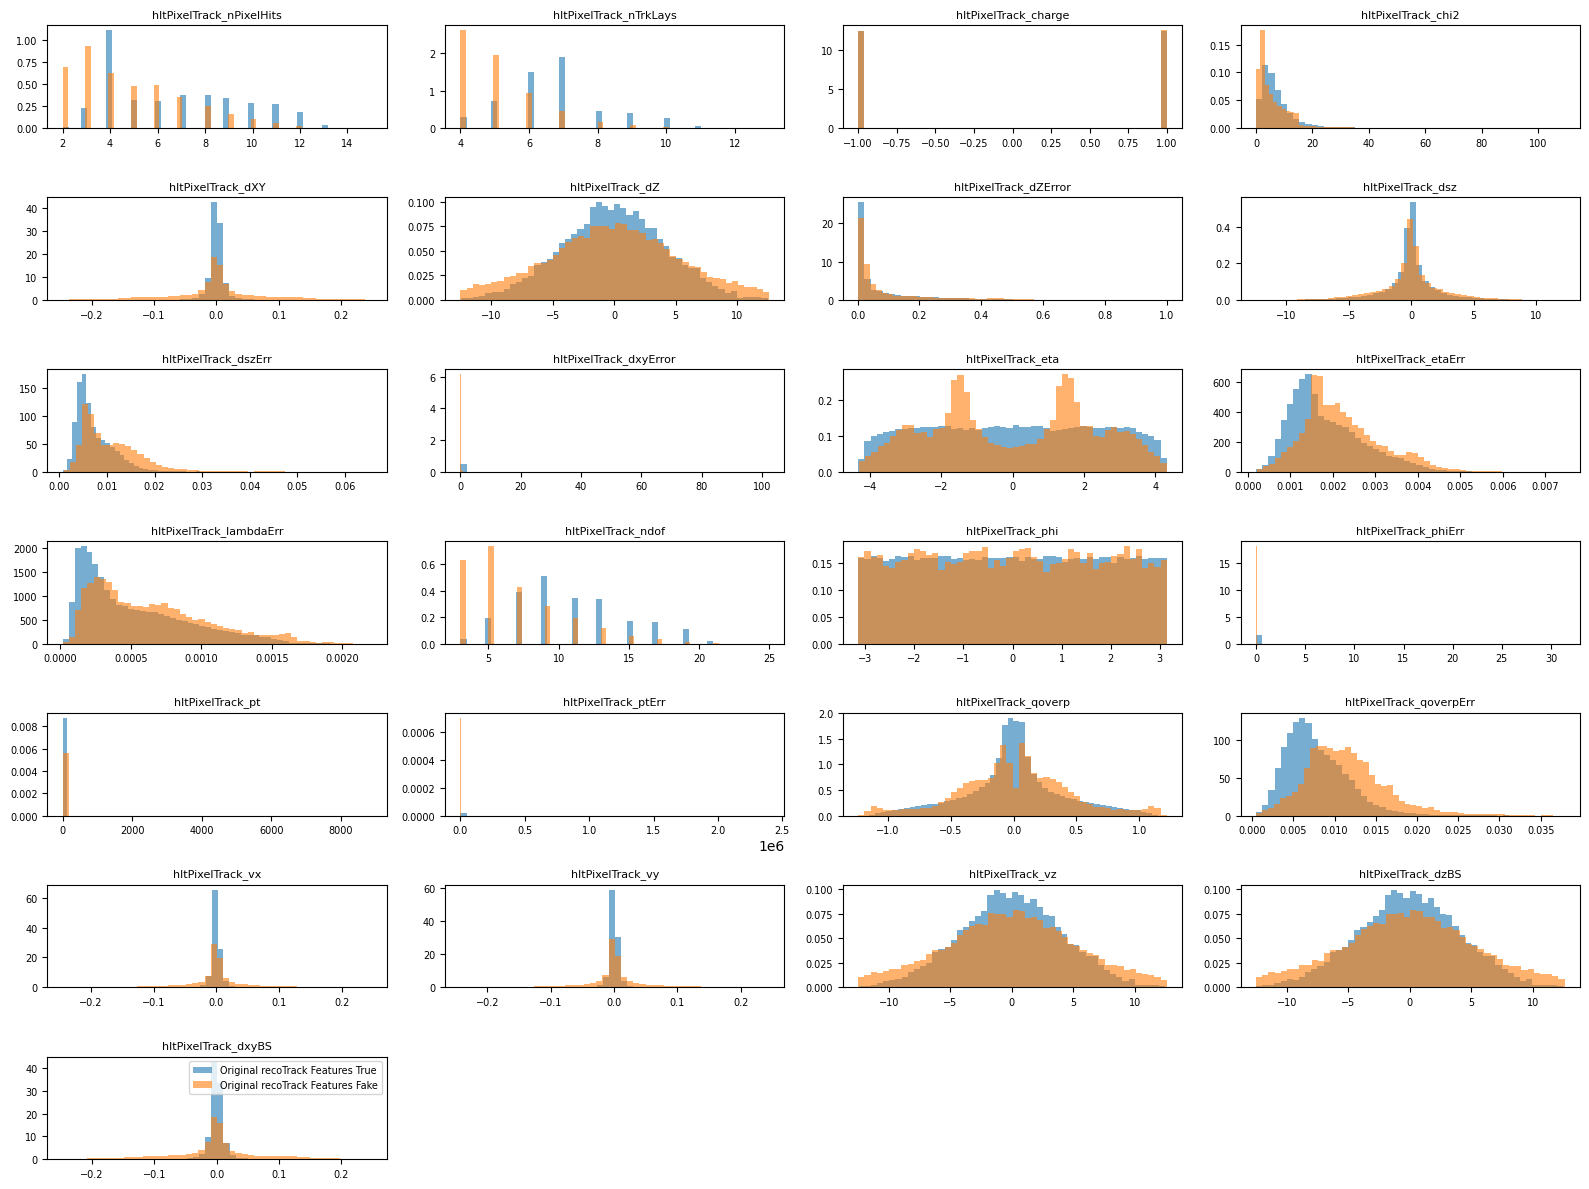

In [12]:
plot_feature_distributions(
    X_ref=recoPixelTrackFeatures,
    feature_names=recoPixelTrackFeatures_names,
    y=recoPixelTrackLabels,
    labels=("Original recoTrack Features",)
)

Apply clipping and log transformation where needed 

### RecHits

## Data saving

In [13]:
save_dict = {
    # --- Core datasets ---
    "recHitFeatures": torch.tensor(recHitFeatures, dtype=torch.float32),
    "isRecHit": ds.mask,
    "recoPixelTrackFeatures": torch.tensor(recoPixelTrackFeatures, dtype=torch.float32),
    "labels": ds.labels,
    "isHighPurity": ds.isHighPurity,

    # --- Normalization stats ---
    "recHit_mean": ds.recHit_mean,
    "recHit_std": ds.recHit_std,
    "recoPixelTrack_mean": ds.recoPixelTrack_mean,
    "recoPixelTrack_std": ds.recoPixelTrack_std,
    
    # --- Metadata ---
    "recHitBranches": ds.recHitBranches,
    "recoPixelTrackBranches": ds.recoPixelTrackBranches,  # exclude label and isHP
    "MAX_HITS": ds.MAX_HITS,
    "EPSILON": ds.EPSILON,
    "LOW_PERCENTILE": ds.LOW_PERCENTILE,
    "HIGH_PERCENTILE": ds.HIGH_PERCENTILE,
    "log_vars": ds.log_vars,
    "clip_vars": ds.clip_vars,
    "log_recHit_vars": ds.log_recHit_vars,
    "do_log_hit": ds.do_log_hit,
    "clip_min_hit": ds.clip_min_hit,
    "clip_max_hit": ds.clip_max_hit,
    "do_log_track": ds.do_log_track,
    "clip_min_track": ds.clip_min_track,
    "clip_max_track": ds.clip_max_track
}

torch.save(save_dict, OUTPUT_PATH)
print(f"✅ Saved preprocessed dataset and parameters to {OUTPUT_PATH}")

✅ Saved preprocessed dataset and parameters to /eos/user/e/ecoradin/GitHub/TrackSelectorDNN/TrackSelectorDNN/data/tracks_train-val_dataset_inference.pt


In [15]:
val_fraction = 0.2
dataset_len = len(save_dict["labels"])
val_len = int(dataset_len * val_fraction)
train_len = dataset_len - val_len

indices = torch.randperm(dataset_len, generator=torch.Generator().manual_seed(42))
train_idx, val_idx = indices[:train_len], indices[train_len:]

def subset_dict(save_dict, indices):
    subset = {}
    # Only split the core dataset tensors
    for key in ["recHitFeatures", "isRecHit", "recoPixelTrackFeatures", "labels", "isHighPurity"]:
        subset[key] = save_dict[key][indices]
    
    # Copy metadata and normalization stats as-is
    for key in ["recHit_mean", "recHit_std", "recoPixelTrack_mean", "recoPixelTrack_std",
                "recHitBranches", "recoPixelTrackBranches", "MAX_HITS", "EPSILON",
                "LOW_PERCENTILE", "HIGH_PERCENTILE", "log_vars", "clip_vars", "log_recHit_vars", 
                "do_log_hit", "clip_min_hit", "clip_max_hit", "do_log_track", "clip_min_track", "clip_max_track"]:
        subset[key] = save_dict[key]
    
    return subset

train_dict = subset_dict(save_dict, train_idx)
val_dict = subset_dict(save_dict, val_idx)

torch.save(train_dict, OUTPUT_PATH_TRAIN)
torch.save(val_dict, OUTPUT_PATH_VAL)
print(f"✅ Saved train and validation datasets with metadata")


✅ Saved train and validation datasets with metadata
